# Setup: OpenCV

For this assignment you will need to use a popular and powerful library known as [OpenCV](https://opencv.org/). To do this on hub, you will need to open a terminal (File->New Launcher->Terminal) and enter `pip install opencv-python`. If you are trying to run the notebook somewhere else and can't figure out how to install the library, ask on piazza and provide details.

# Assignment: Solving Image Maze 

Given a maze as an image with a start and end point, we would like to write code to solve the maze. 

An image is a 2D matrix of pixels of a particular size that depends on its resolution. Each 
pixel has a color which is given by its Red, Green and Blue (RGB) values.
 
Given an image, we will view it as a graph where each pixel of the image is a vertex 
and edges connect a pixel to its neighbor. The weight of an edge should be very small if
the pixel colors are similar (i.e, the differences between r, g and b values are close to zero)
and correspondingly large as the pixel colors diverge.
  
Next, given a source pixel $(i_0, j_0)$ and destination pixel, 
$(i_1, j_1)$, we wish find the shortest weight path from source to destination.

You should use the Dijkstra's algorithm modified in two ways:
   - It can exit as soon as the destination is reached.
   - A 1000 x 1000 pixel image gives rise to a graph with million vertices. Storing such a graph as an adjacency list is going to be very memory intensive. Instead, your goal will be to generate the vertices and edges *on-the-fly*.
   
We will use opencv library, a popular computer vision library to load, and manipulate images of mazes.



## Manipulating Images

You can directly manipulate images in python in many ways. The `opencv` library is considered a standard for numerous
image manipulation tasks.

Here we load an image `maze.png` and you can see it nicely plotted with coordinates. We then show you two pixels
shown in red and blue. The goal here is to detect a path from one of the colored circle to the other, in the maze without crossing
the black pixels.

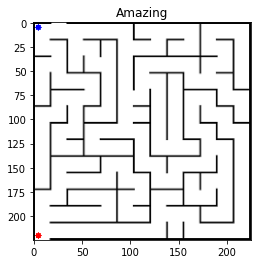

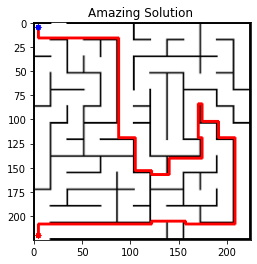

In [1]:
from matplotlib import pyplot as plt
import cv2
# You can read png, jpg and other file types 
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

img = cv2.imread('maze-solution.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing Solution ')
plt.show()


Given an image it is simple to read the color at a pixel. Let us read the color at pixel (645, 67)

In [2]:
print('Image size (height, width, num layers) is', img.shape)
px = img[145, 67] # img[y,x] is the color of the pixel of x,y
print(px)

cv2.circle(img, (80, 18), 3, (198,31,4),-1) # Draw a colored circle centered at (80, 18)
px1 = img[18, 80] # It is important to note that rows of the image are y values and columns are x values.
print(px1)

px2 = img[80, 18] # This is important to note that indexing the img data structure takes y, x values.
# Most opencv functions will require (x,y) coordinates for pixel as is natural.
print(px2)

Image size (height, width, num layers) is (225, 225, 3)
[255 255 255]
[198  31   4]
[0 0 0]


The pixel color is expressed in RGB format. R is the red value from 0 -> 255, G is the green value 0 -> 255 and B is the blue value from 0 -> 255 

We will now define a edge weight function for an edge in the image

In [3]:
import math 
def fixPixelValues(px):
    # convert the RGB values into floating point to avoid an overflow that will give me wrong answers
    return [ float(px[0]), float(px[1]), float(px[2]) ]

## Given (x,y) coordinates of two neighboring pixels, calculate the edge weight.
# We take the squared euclidean distance between the pixel values and add 0.1
def getEdgeWeight(img, u, v):
    # get edge weight for edge between u, v
    # First make sure that the edge is legit
    i0,j0 = u[0], u[1]
    i1,j1 = v[0], v[1]
    height, width, _ = img.shape
    assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
    assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
    assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
    assert -1 <= j0 - j1 <= 1
    px1 = fixPixelValues(img[j0,i0])
    px2 = fixPixelValues(img[j1,i1])
    return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2
    
# This is a useful function that given a list of (x,y) values, 
# draw a series of red lines between each coordinate and next to 
# show the path in the image
def drawPath(img, path, pThick=2):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img,(x,y), (x0,y0), (255,0,0),pThick)
        x0, y0 = x,y
        

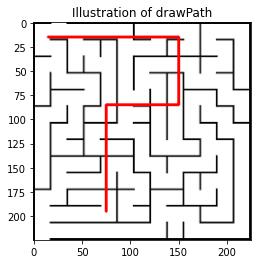

In [4]:
# Example
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
drawPath(img, [ (15, 15), (150, 15), (150, 85), (75, 85), (75, 195)])
plt.imshow(img) # show the image on the screen 
plt.title('Illustration of drawPath')
plt.show()

## Step 1: Compute Single Source Shortest Path For an Image

Given an image, compute the  shortest path between source and destination pixels by modifying Dijkstra's algorithm. __Your challenge  is to implement it without needing to create the entire the adjacency list for the graph
in the first place. However, for simplicity you can try a first cut implementation of a generic Dijkstra algorithm over
graphs represented as adjacency matrix or list.__ 

In [5]:
class Vertex: # This is the outline for a vertex data structure
    def __init__ (self,  i, j):
        self.x = i # The x coordinate
        self.y = j  # The y coordinate
        self.d = float('inf') # the shortest path estimate
        self.processed = False # Has this vertex's final shortest path distance been computed
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex.
        
    # relax edge v->n
    def update_vertex_weight(self, img, v):
        weight = getEdgeWeight(img, [v.x, v.y], [self.x, self.y])
        if self.d > v.d + weight:
            self.d = v.d + weight
            self.pi = v
        
# Dijkstra's algorithm requires a priority queue so that the 
# minimum weight vertex can be found efficiently.
# However, we provide you with a list data structure as a stand in for priority queue

class SimpleQueue: 
    # CONSTRUCTOR
    def __init__(self): 
        self.q = []
        
    # Insert a vertex into the queue
    def insert(self, v):
        v.idx_in_priority_queue = len(self.q)
        self.q.append(v)
        
    # Find the vertex with the smallest distance estimate, and 
    # delete it from the queue
    # return the vertex
    def get_and_delete_min(self):
        n = len(self.q)
        assert n > 0
        min_pos = 0
        for i in range(n):
            if self.q[i].d < self.q[min_pos].d:
                min_pos = i
        v = self.q[min_pos]
        del self.q[min_pos]
        return v
    
    # Is the queue empty?
    def is_empty(self):
        return len(self.q) == 0
    
    # Notify the queue that the weight of vertex v has been updated.
    def update_vertex_weight(self, v):
        pass # Nothing to do, for a simple list, we ignore this notification.
    


In [6]:
# However, if you want Dijkstra efficiently, 
# you may want to implement a priority queue.
# We provide you the signature for a priority queue.
# Feel free to implement extra functions if you wish

import heapq

class PriorityQueue:
    # Constructor: 
    def __init__(self):
        # YOUR CODE HERE
        self.queue = []
    
    def insert(self, v):
        # YOUR CODE HERE
        heapq.heappush(self.queue, (v.d, v.x, v.y, v))
    
    def get_and_delete_min(self):
        # YOUR CODE HERE: must return a vertex
        n = len(self.queue)
        assert n > 0
        deleted = heapq.heappop(self.queue)[3]
        deleted.processed = True
        return deleted
    
    def is_empty(self):
        # YOUR CODE HERE: must return true/false
        return True if len(self.queue) == 0 else False

        
    def update_vertex_weight(self, v):
        pass # YOUR CODE HERE
        # implemented in Vertex class
        

In [7]:
# Helper functions
def bounds_checker(img, nabe, measure):
    # grab img dimensions
    height, width, _ = img.shape

    if measure == 1:  # if width
        location = nabe[0][0]  # location is x-coord
        measure = width
    else:             # if height
        location = nabe[0][1]  # location is y-coord
        measure = height

    return True if 0 <= location < measure else False  # if coord within bounds return True, else False


def neighbor_grabber(img, pqueue, visited, v):
    # neighbors of v
    # coding for use in bounds_checker() : weight = 1, height = 2
    nabes = [[(v.x + 1, v.y), 1], [(v.x - 1, v.y), 1], [(v.x, v.y + 1), 2], [(v.x, v.y - 1), 2]]

    for nabe in nabes:
        if bounds_checker(img, nabe, nabe[1]):
            # if already visited, relax
            if nabe[0] in visited:
                visited[nabe[0]].update_vertex_weight(img, v)
            # else, create it
            else:
                neighbor = Vertex(nabe[0][0], nabe[0][1])
                neighbor.update_vertex_weight(img, v)
                pqueue.insert(neighbor)
                visited[(neighbor.x, neighbor.y)] = neighbor


def recover_solution(current_node, vertex, soln):
    # backtrack to recover solution
    while current_node != vertex:
        soln.append((current_node.x, current_node.y))
        # print('x', current_node.x, 'y', current_node.y, 'processed', current_node.processed)
        current_node = current_node.pi  # update current node
    soln.append((vertex.x, vertex.y))  # append starting vertex

In [8]:
def computeShortestPath(img, source, dest): 
    # IMPLEMENT DIJKSTRA
    # create source vertex from xytuple
    vertex = Vertex(source[0], source[1])
    vertex.d = 0.0
    # dictionary to track vertices we've already encountered
    visited = {source: vertex}
    # instantiate priority queue to assist with Dijkstra's Algorithm
    pqueue = PriorityQueue()
    pqueue.insert(vertex)

    while not pqueue.is_empty():
        # retrieve vertex with smallest d value
        current_node = pqueue.get_and_delete_min()
        # modify Dijkstra to exit when destination vertex is reached
        if (current_node.x == dest[0]) and (current_node.y == dest[1]):
            break
        # else, get neighbors of current vertex
        else:
            neighbor_grabber(img, pqueue, visited, current_node)

    soln = []
    recover_solution(current_node, vertex, soln)
    return soln

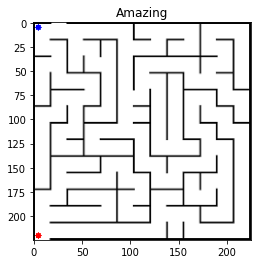

In [9]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

In [10]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (5,220), (5,5))

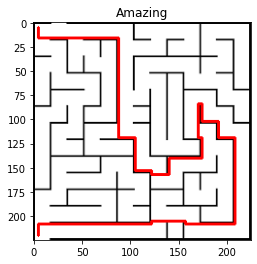

True

In [11]:
drawPath(img, p, 2)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()
cv2.imwrite('maze-solution.png', img)

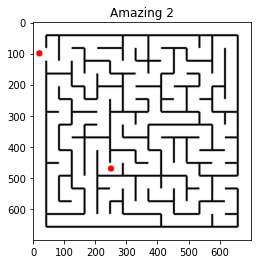

In [12]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
cv2.circle(img,(250,470), 10, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (20,100), 10, (255,0,0), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 2')
plt.show()

In [13]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (250,470), (20,100))

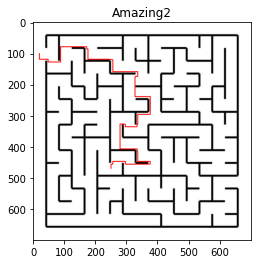

In [14]:
drawPath(img,p)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2')
plt.show()

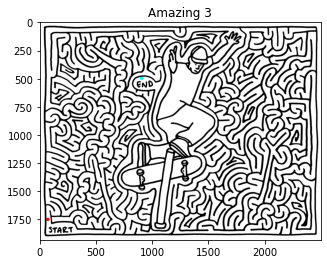

In [15]:
img = cv2.imread('maze3.JPG')
cv2.circle(img,(70,1750), 15, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (900,500), 15, (0,255,255), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 3')
plt.show()

In [16]:
img = cv2.imread('maze3.JPG') # read an image from a file using opencv (cv2) library
p = computeShortestPath(img, (70,1750), (900,500))

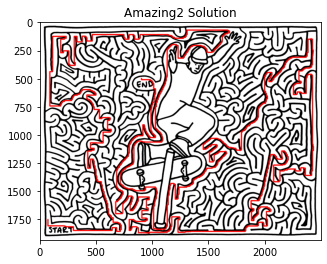

In [17]:
drawPath(img,p,10)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()